In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Estilo para os gr√°ficos
sns.set(style="whitegrid", font_scale=1.1)

In [7]:
# Substitua o caminho caso os arquivos estejam em outro diret√≥rio
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/evaluation_results_icl_with_repetitions_torcedor.json", "r", encoding="utf-8") as f:
    dados_torcedor = json.load(f)

with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/evaluation_results_icl_with_repetitions_tecnico.json", "r", encoding="utf-8") as f:
    dados_tecnico = json.load(f)

In [8]:
def expand_icl_data(dados, perfil):
    linhas = []
    for exemplo in dados:
        for i in range(len(exemplo["scores_zero_shot"])):
            linhas.append({
                "pergunta": exemplo["pergunta"],
                "perfil": perfil,
                "criterio": exemplo["criterio"],
                "repeticao": i + 1,
                "zero_shot": exemplo["scores_zero_shot"][i],
                "one_shot": exemplo["scores_one_shot"][i],
                "few_shot": exemplo["scores_few_shot"][i],
            })
    return pd.DataFrame(linhas)

df_torcedor = expand_icl_data(dados_torcedor, "Torcedor")
df_tecnico = expand_icl_data(dados_tecnico, "T√©cnico")

df = pd.concat([df_torcedor, df_tecnico], ignore_index=True)

In [10]:
df.shape

(1400, 7)

In [13]:
resultados_teste = []

for perfil in df["perfil"].unique():
    for criterio in df["criterio"].unique():
        subset = df[(df["perfil"] == perfil) & (df["criterio"] == criterio)]

        stat_1, p_1 = ttest_rel(subset["zero_shot"], subset["one_shot"])
        stat_2, p_2 = ttest_rel(subset["zero_shot"], subset["few_shot"])
        stat_3, p_3 = ttest_rel(subset["one_shot"], subset["few_shot"])

        resultados_teste.append({
            "Perfil": perfil,
            "Crit√©rio": criterio,
            "Zero vs One (p)": round(p_1, 4),
            "Zero vs Few (p)": round(p_2, 4),
            "One vs Few (p)": round(p_3, 4),
            "Significativo Z‚ÜîO": "‚úÖ" if p_1 < 0.05 else "‚ùå",
            "Significativo Z‚ÜîF": "‚úÖ" if p_2 < 0.05 else "‚ùå",
            "Significativo O‚ÜîF": "‚úÖ" if p_3 < 0.05 else "‚ùå",
        })

df_resultado = pd.DataFrame(resultados_teste)
df_resultado

Perfil                    Crit√©rio  Zero vs One (p)  Zero vs Few (p)  \
0   Torcedor           AdequacaoAoPerfil           0.0000            0.000   
1   Torcedor  UsoDeInformacoesRelevantes           0.0000            0.000   
2   Torcedor          TomEEstiloAdequado           0.0000            0.000   
3   Torcedor        ClarezaNaComunicacao           0.0000            0.000   
4   Torcedor     PersonalizacaoExplicita           0.0017            0.000   
5   Torcedor    SelecaoDeDadosRelevantes           0.0000            0.000   
6   Torcedor       AusenciaDeAlucinacoes           0.0000            0.533   
7    T√©cnico           AdequacaoAoPerfil           0.2713            0.000   
8    T√©cnico  UsoDeInformacoesRelevantes           0.0050            0.000   
9    T√©cnico          TomEEstiloAdequado           0.0050            0.000   
10   T√©cnico        ClarezaNaComunicacao           0.0000            0.000   
11   T√©cnico     PersonalizacaoExplicita           0.0000            0.000   
12   T√©cnico    SelecaoDeDadosRelevantes           0.0189            0.000   
13   T√©cnico       AusenciaDeAlucinacoes           0.0002            0.000   

    One vs Few (p) Significativo Z‚ÜîO Significativo Z‚ÜîF Significativo O‚ÜîF  
0           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
1           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
2           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
3           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
4           0.8677                 ‚úÖ                 ‚úÖ                 ‚ùå  
5           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
6           0.0000                 ‚úÖ                 ‚ùå                 ‚úÖ  
7           0.0000                 ‚ùå                 ‚úÖ                 ‚úÖ  
8           0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
9           0.0088                 ‚úÖ                 ‚úÖ                 ‚úÖ  
10          0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
11          0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
12          0.0000                 ‚úÖ                 ‚úÖ                 ‚úÖ  
13          0.0789                 ‚úÖ                 ‚úÖ                 ‚ùå

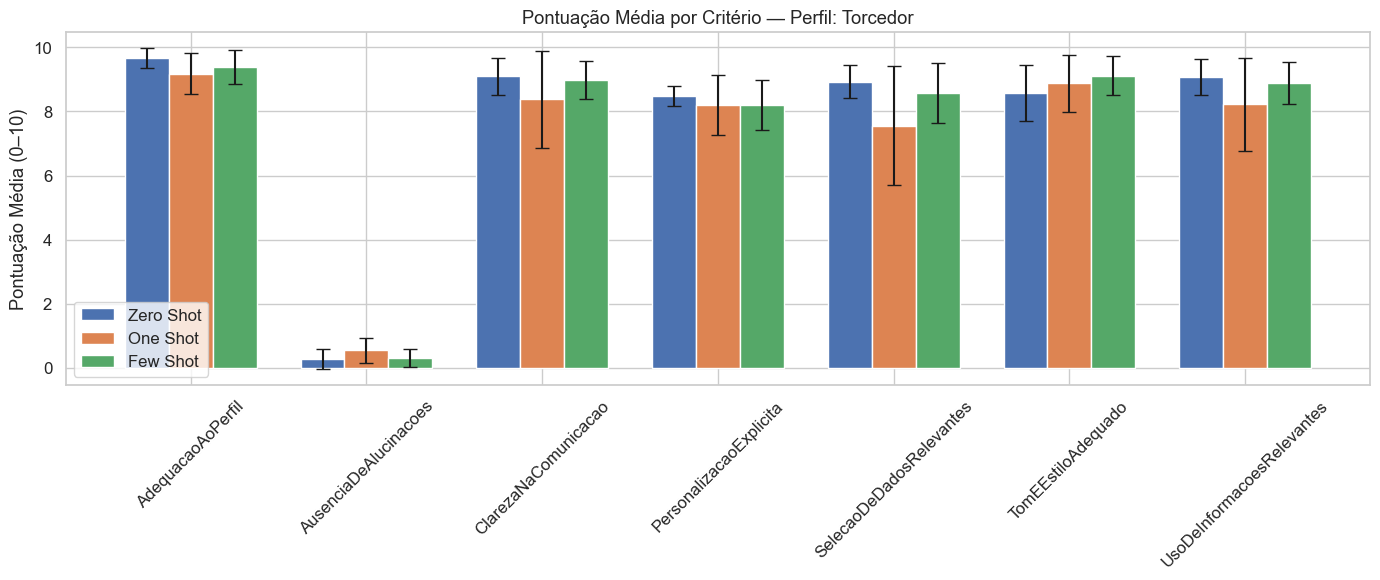

In [15]:
df_agg = df.groupby(["perfil", "criterio"])[["zero_shot", "one_shot", "few_shot"]].agg(["mean", "std"]).reset_index()
df_agg.columns = ["perfil", "criterio",
                  "ZeroShot_M√©dia", "ZeroShot_DP",
                  "OneShot_M√©dia", "OneShot_DP",
                  "FewShot_M√©dia", "FewShot_DP"]

# Exemplo para perfil Torcedor
dados_torcedor = df_agg[df_agg["perfil"] == "Torcedor"]

x = np.arange(len(dados_torcedor["criterio"]))
largura = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - largura, dados_torcedor["ZeroShot_M√©dia"], width=largura, yerr=dados_torcedor["ZeroShot_DP"], capsize=5, label="Zero Shot")
ax.bar(x, dados_torcedor["OneShot_M√©dia"], width=largura, yerr=dados_torcedor["OneShot_DP"], capsize=5, label="One Shot")
ax.bar(x + largura, dados_torcedor["FewShot_M√©dia"], width=largura, yerr=dados_torcedor["FewShot_DP"], capsize=5, label="Few Shot")

ax.set_xticks(x)
ax.set_xticklabels(dados_torcedor["criterio"], rotation=45)
ax.set_ylabel("Pontua√ß√£o M√©dia (0‚Äì10)")
ax.set_title("Pontua√ß√£o M√©dia por Crit√©rio ‚Äî Perfil: Torcedor")
ax.legend()
plt.tight_layout()
plt.show()

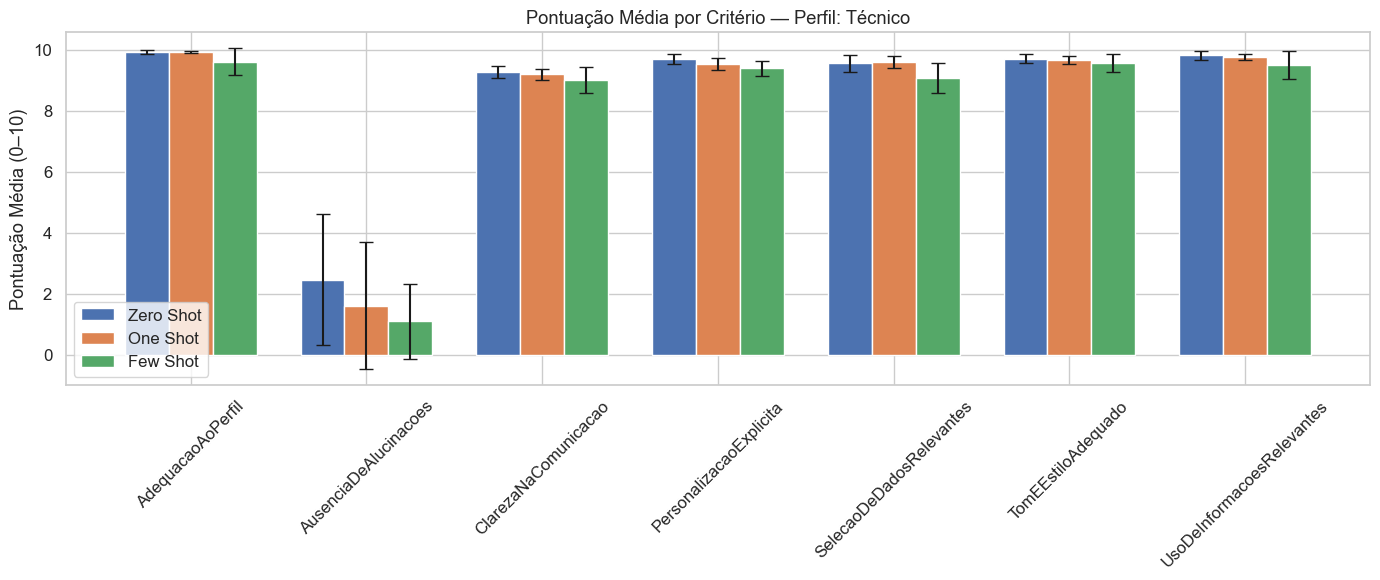

In [31]:
# Exemplo para perfil Torcedor
dados_tecnico = df_agg[df_agg["perfil"] == "T√©cnico"]

x = np.arange(len(dados_tecnico["criterio"]))
largura = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - largura, dados_tecnico["ZeroShot_M√©dia"], width=largura, yerr=dados_tecnico["ZeroShot_DP"], capsize=5, label="Zero Shot")
ax.bar(x, dados_tecnico["OneShot_M√©dia"], width=largura, yerr=dados_tecnico["OneShot_DP"], capsize=5, label="One Shot")
ax.bar(x + largura, dados_tecnico["FewShot_M√©dia"], width=largura, yerr=dados_tecnico["FewShot_DP"], capsize=5, label="Few Shot")

ax.set_xticks(x)
ax.set_xticklabels(dados_tecnico["criterio"], rotation=45)
ax.set_ylabel("Pontua√ß√£o M√©dia (0‚Äì10)")
ax.set_title("Pontua√ß√£o M√©dia por Crit√©rio ‚Äî Perfil: T√©cnico")
ax.legend()
plt.tight_layout()
plt.show()

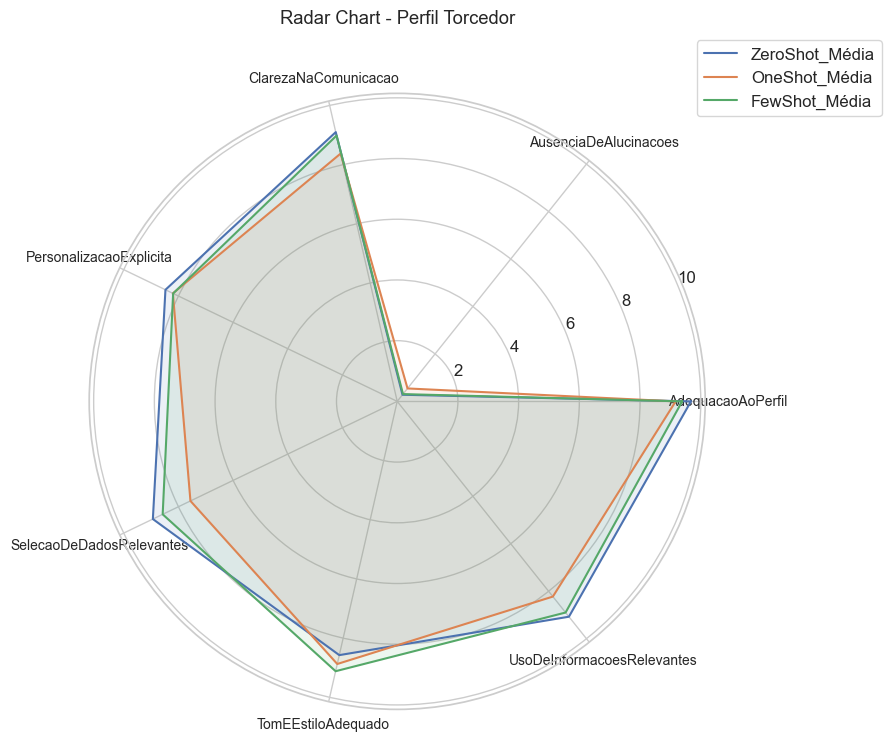

In [27]:
from math import pi
import matplotlib.pyplot as plt

# Converter para estrutura adequada
radar_data = dados_torcedor.set_index("criterio")[["ZeroShot_M√©dia", "OneShot_M√©dia", "FewShot_M√©dia"]].T
categorias = radar_data.columns.tolist()  # ‚úÖ sem duplicar

# √Çngulos para o radar
angles = [n / float(len(categorias)) * 2 * pi for n in range(len(categorias))]
angles += [angles[0]]  # Fechar o c√≠rculo nos √¢ngulos

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in radar_data.iterrows():
    valores = row.tolist()
    valores += [valores[0]]  # Fechar c√≠rculo nos valores
    ax.plot(angles, valores, label=i)
    ax.fill(angles, valores, alpha=0.1)

ax.set_xticks(angles[:-1])  # os √¢ngulos das categorias
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Radar Chart - Perfil Torcedor", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [ ]:
import pandas as pd
from evaluate import load
from rapidfuzz.distance import Levenshtein
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

# M√©tricas do HuggingFace Evaluate
bertscore = load("bertscore")
rouge = load("rouge")
bleu = load("bleu")

In [29]:
def jaccard_similarity(str1, str2):
    vec = CountVectorizer(binary=True).fit([str1, str2])
    x = vec.transform([str1]).toarray()
    y = vec.transform([str2]).toarray()
    return jaccard_score(x[0], y[0])

def get_metrics(text1, text2):
    metrics = {}

    # BERTScore
    bs = bertscore.compute(predictions=[text1], references=[text2], lang="en")
    metrics["BERTScore"] = round(bs["f1"][0], 4)

    # ROUGE
    r = rouge.compute(predictions=[text1], references=[text2], rouge_types=["rougeL"])
    metrics["ROUGE_L"] = round(r["rougeL"], 4)

    # BLEU ‚Äì corrigido aqui
    b = bleu.compute(predictions=[text1], references=[text2])
    metrics["BLEU"] = round(b["bleu"], 4)

    # Jaccard
    try:
        metrics["Jaccard"] = round(jaccard_similarity(text1, text2), 4)
    except ValueError:
        metrics["Jaccard"] = 0.0
    except Exception as e:
        print(f"An error occurred while calculating Jaccard similarity: {e}")
        metrics["Jaccard"] = 0.0

    # Edit Distance
    dist = Levenshtein.normalized_distance(text1, text2)
    metrics["Edit_Dist"] = round(1 - dist, 4)

    return metrics

In [22]:
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_icl_torcedor.json", "r", encoding="utf-8") as f:
    respostas_torcedor = json.load(f)

with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_icl_tecnico.json", "r", encoding="utf-8") as f:
    respostas_tecnico = json.load(f)

In [23]:
def gerar_comparacoes_variacao(dados, perfil):
    linhas = []
    for exemplo in dados:
        pergunta = exemplo["pergunta"]
        res_zero = exemplo["resposta_zero_shot"]
        res_one = exemplo["resposta_one_shot"]
        res_few = exemplo["resposta_few_shot"]

        for par, t1, t2 in [
            ("Zero vs One", res_zero, res_one),
            ("Zero vs Few", res_zero, res_few),
            ("One vs Few", res_one, res_few),
        ]:
            metrics = get_metrics(t1, t2)
            metrics["par"] = par
            metrics["pergunta"] = pergunta
            metrics["perfil"] = perfil
            linhas.append(metrics)

    return pd.DataFrame(linhas)

df_var_torcedor = gerar_comparacoes_variacao(respostas_torcedor, "Torcedor")
df_var_tecnico = gerar_comparacoes_variacao(respostas_tecnico, "T√©cnico")
df_variacao = pd.concat([df_var_torcedor, df_var_tecnico], ignore_index=True)

df_variacao.head()

BERTScore  ROUGE_L    BLEU  Jaccard  Edit_Dist          par  \
0     0.9165   0.5046  0.4053   0.4886     0.4615  Zero vs One   
1     0.9210   0.5581  0.4427   0.5060     0.5000  Zero vs Few   
2     0.9169   0.5148  0.4508   0.4681     0.5041   One vs Few   
3     0.8752   0.3636  0.2175   0.3418     0.3745  Zero vs One   
4     0.9006   0.5625  0.3322   0.4648     0.4841  Zero vs Few   

                                            pergunta    perfil  
0  Bruno Pacheco foi bem no jogo contra o Cear√° n...  Torcedor  
1  Bruno Pacheco foi bem no jogo contra o Cear√° n...  Torcedor  
2  Bruno Pacheco foi bem no jogo contra o Cear√° n...  Torcedor  
3  Qual jogador do Fortaleza correu mais r√°pido d...  Torcedor  
4  Qual jogador do Fortaleza correu mais r√°pido d...  Torcedor

In [24]:
agrupado = df_variacao.groupby(["perfil", "par"]).mean(numeric_only=True).round(4)
agrupado.reset_index(inplace=True)
agrupado

perfil          par  BERTScore  ROUGE_L    BLEU  Jaccard  Edit_Dist
0  Torcedor   One vs Few     0.8973   0.4644  0.3179   0.3942     0.4174
1  Torcedor  Zero vs Few     0.8949   0.4651  0.2935   0.3931     0.4337
2  Torcedor  Zero vs One     0.8891   0.3950  0.2506   0.3691     0.4065
3   T√©cnico   One vs Few     0.9083   0.4661  0.3522   0.4216     0.4619
4   T√©cnico  Zero vs Few     0.8879   0.4114  0.2642   0.3655     0.3966
5   T√©cnico  Zero vs One     0.8915   0.4478  0.3287   0.4102     0.4117

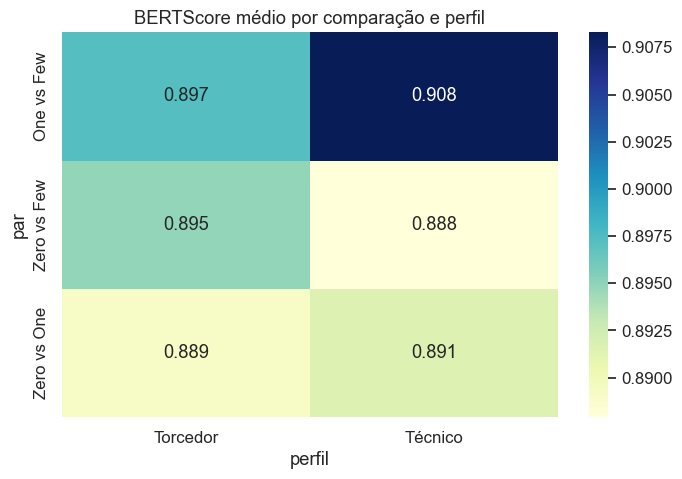

In [25]:
pivot = agrupado.pivot(index="par", columns="perfil", values="BERTScore")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("BERTScore m√©dio por compara√ß√£o e perfil")
plt.show()

# An√°lise

üîç 1. An√°lise dos Resultados do G-Eval (Qualidade da Resposta)

Perfil: Torcedor do Time

Gr√°fico: Barras com m√©dia e desvio padr√£o por crit√©rio
	‚Ä¢	Adequa√ß√£o ao Perfil: Todas as abordagens pontuaram bem. Zero-shot foi ligeiramente superior, indicando que mesmo sem exemplos, a estrutura da resposta j√° atende bem √†s expectativas do torcedor.
	‚Ä¢	Aus√™ncia de Alucina√ß√µes: Baix√≠ssimo em todas as abordagens, mas com Zero-shot levemente melhor. Isso sugere que o uso de exemplos no prompt n√£o est√° ajudando a evitar inven√ß√µes, e possivelmente est√° at√© induzindo informa√ß√µes extras.
	‚Ä¢	Tom e Estilo Adequado / Personaliza√ß√£o Expl√≠cita: Pouca varia√ß√£o entre abordagens. Few-shot foi discretamente melhor, o que pode indicar um leve ganho na adapta√ß√£o do tom.
	‚Ä¢	Sele√ß√£o e Uso de Dados Relevantes: Few-shot e Zero-shot tiveram melhor desempenho que o One-shot. Pode indicar que apenas um exemplo n√£o √© suficiente para alterar o foco da resposta.

Perfil: T√©cnico do Time

Gr√°fico: Barras com m√©dia e desvio padr√£o por crit√©rio
	‚Ä¢	Adequa√ß√£o ao Perfil / Clareza / Tom T√©cnico: Altas pontua√ß√µes em todas as abordagens. Zero-shot e One-shot lideram.
	‚Ä¢	Aus√™ncia de Alucina√ß√µes: Melhor em Zero-shot, com decl√≠nio vis√≠vel em Few-shot. Isso sugere que a adi√ß√£o de muitos exemplos pode induzir informa√ß√µes irrelevantes ou fict√≠cias para esse perfil t√©cnico.
	‚Ä¢	Sele√ß√£o de Dados Relevantes: Zero e One-shot est√£o levemente acima, indicando que o modelo j√° sabe o que √© relevante para esse perfil mesmo sem exemplos adicionais.

‚∏ª

üß† 2. An√°lise das M√©tricas de Varia√ß√£o Textual

BERTScore
	‚Ä¢	Os valores ficaram muito altos (~0.89‚Äì0.91), indicando que as respostas geradas pelas tr√™s abordagens s√£o semanticamente bastante similares.
	‚Ä¢	A maior diferen√ßa foi entre One vs Few para o T√©cnico (0.908), sugerindo que o Few-shot come√ßou a desviar levemente no conte√∫do e estrutura para esse perfil.

BLEU, ROUGE-L, Jaccard, Edit Distance
	‚Ä¢	Mostram maior varia√ß√£o entre One vs Few e Zero vs Few, refor√ßando a ideia de que Few-shot gera respostas mais diferentes em termos de palavras usadas, estilo e organiza√ß√£o.
	‚Ä¢	A dist√¢ncia textual entre as respostas √© um pouco maior para o perfil T√©cnico do que para o Torcedor, sugerindo que os exemplos de Few-shot foram mais impactantes nesse caso.

‚∏ª

üß© Conclus√µes Gerais

‚úÖ Varia√ß√£o Textual Aumenta com Few-shot
	‚Ä¢	As m√©tricas confirmam que Few-shot produz as respostas mais distintas, mesmo que semanticamente pr√≥ximas (alto BERTScore).
	‚Ä¢	Isso √© positivo se o objetivo for explorar varia√ß√µes no estilo ou foco.

‚ö†Ô∏è Qualidade Geral n√£o melhora com mais exemplos
	‚Ä¢	Zero-shot se manteve competitivo (e at√© superior) em crit√©rios como clareza, adequa√ß√£o e aus√™ncia de alucina√ß√£o.
	‚Ä¢	Isso pode indicar que, para dom√≠nios bem estruturados com dados tabulares claros, o modelo j√° tem forte desempenho mesmo sem exemplos expl√≠citos.

üß™ Perfil T√©cnico √© mais sens√≠vel a alucina√ß√µes com Few-shot
	‚Ä¢	Exige maior cuidado na curadoria dos exemplos fornecidos.
	‚Ä¢	Sugere que para p√∫blicos mais t√©cnicos, menos √© mais em termos de contexto adicional.

‚∏ª

üí° Sugest√µes
	‚Ä¢	Para perfis leigos (torcedor, jornalista, crian√ßa): o Few-shot pode ser √∫til para variar tom e estilo.
	‚Ä¢	Para perfis t√©cnicos: preferir Zero ou One-shot com prompts bem diretos e precisos.
	‚Ä¢	Investigar formas de construir exemplos otimizados para evitar alucina√ß√µes e redund√¢ncias no Few-shot.